# [GD-4] CutMix 또는 Mixup 비교실험 하기

### 실습목표

---

- **Augmentation을 모델 학습에 적용하기**
- **Augmentation의 적용을 통한 학습 효과 확인하기**
- **최신 data augmentation 기법 구현 및 활용하기**

<br>

### **준비물**

---

**`~/aiffel/data_augmentation` 폴더가 필요, 개인 실습환경에 맞추어 경로를 변경, 디렉토리를 생성해 주세요.**

```
$ mkdir -p ~/aiffel/data_augmentation/data
```

## Step 0 필요한 라이브러리 불러오기

In [ ]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, applications, optimizers
import tensorflow_datasets as tfds
import urllib3
urllib3.disable_warnings()


# Helper libaries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Step 1. 데이터 전처리
### 1.1 데이터 불러오기
- ds_train, ds_val, da_test로 검증을 ds_val로 하고, ds_test로 evaluate할 예정

In [ ]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'stanford_dogs', split=['train', 'test[:50%]', 'test[50%:]'], as_supervised=True, shuffle_files=True, with_info=True,)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteX0NLOY/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteX0NLOY/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


### 1.2 dataset 기본 정보확인

In [ ]:
# Tensorflow 데이터셋 feature 정보 확인 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})


In [ ]:
# 데이터의 개수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_val))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(12000, shape=(), dtype=int64)
tf.Tensor(4290, shape=(), dtype=int64)
tf.Tensor(4290, shape=(), dtype=int64)


In [ ]:
# 라벨의 개수
ds_info.features["label"].num_classes

120

In [ ]:
# 라벨의 이름
ds_info.features["label"].names

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound',
 'n02091032-italian_greyhound',
 'n02091134-whippet',
 'n02091244-ibizan_hound',
 'n02091467-norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-saluki',
 'n02092002-scottish_deerhound',
 'n02092339-weimaraner',
 'n02093256-staffordshire_bullterrier',
 'n02093428-american_staffordshire_terrier',
 'n02093647-bedlington_terrier',
 'n02093754-border_terrier',
 'n02093859-kerry_blue_terrier',
 'n02093991-irish_terrier',
 'n02094114-norfolk_terrier',
 'n02094258-norwi

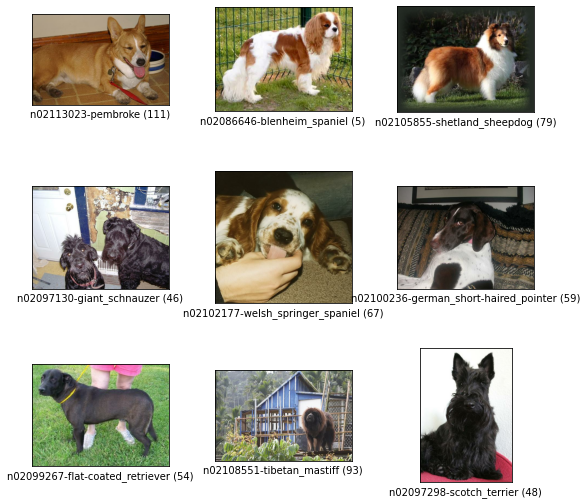

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

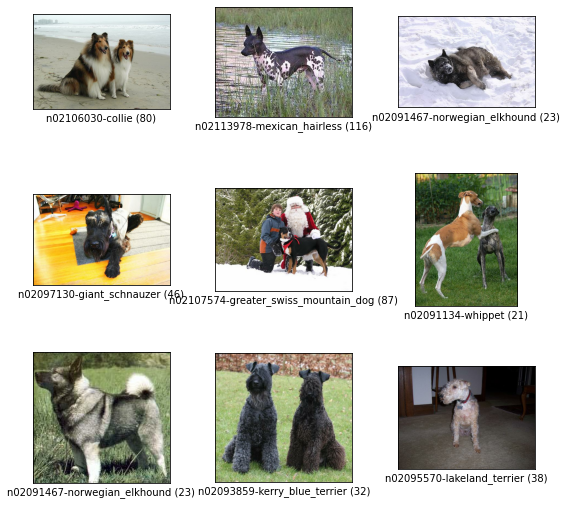

In [ ]:
# test 이미지 보기
fig = tfds.show_examples(ds_test, ds_info)

## Step 2. 이미지 전처리

### 2.1 텐서플로우 API를 이용한 Augmentaion 활용

#### tensorflow augmentation 함수

- **`random_brightness()`**
- **`random_contrast()`**
- **`random_crop()`**
- **`random_flip_left_right()`**
- **`random_flip_up_down()`**
- **`random_hue()`**
- **`random_jpeg_quality()`**
- **`random_saturation()`**

In [ ]:
# 기본적인 전처리 함수
def normalize_and_resize_img(image, label):
    """Normalises images:`unit8` -> `float2`"""
    image = tf.image.resize(image, [224,224])
 
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    
    return image, label

In [ ]:
# 데이터셋(ds)를 가공하는 매인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    
    if not is_test and with_aug:
        ds = ds.map(augment, num_parallel_calls=2)
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

ds_train_orig = apply_normalize_on_dataset(ds_train, with_aug=False)

### 2.2 CutMix
- 이미지의 일정 영역을 자라서 다른 이미지에 붙여주는 방법
- 배치 내의 이미지를 두 개 골라 바운딩 박스의 위치를 랜덤하게 뽑고, 해당 영역을 잘라내서 두 개의 이미지를 섞어준다.
- 섞인 이미지의 전체 이미지에 대비 비율을 계산하고, 면적에 비례햇 두 라벨을 섞어준다.

In [ ]:
num_classes = ds_info.features['label'].num_classes
num_classes

120

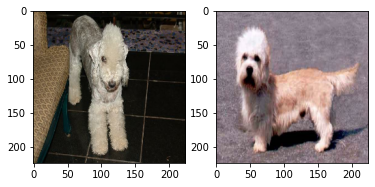

In [ ]:
# 데이터셋에서 이미지를 2개를 가져옵니다.
for i, (image, label) in enumerate(ds_train_orig.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break
        
plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [ ]:
# 바탕 이미지 a애 삽입될 영역의 바운딩 바스의 위치를 결정하는 함수
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(110, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(83, shape=(), dtype=int32)


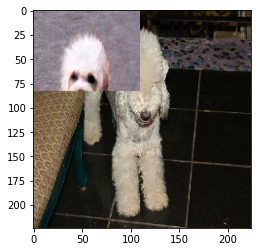

In [ ]:
# 바탕이미지에 a에 바운딩 박스 바낕쪽 영역을 다른 이미지 b에서  바운딩 박스 안쪽 영역을 가져와서 합치는 함수
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()    

In [ ]:
# 섞인 이미지의 면적에 비례해서 라벨을 섞어주는 함수
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=num_classes):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.8180405 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.18195951, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [ ]:
# 위에서 구현한 두 함수를 활용하여 배치 단위의 cutmix() 함수 구현
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=num_classes):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## 2.3 Mixup
- 두 개의 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식
- 두 이미지를 섞을 비율을 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어준다.

In [ ]:
# functio for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape) == 0:
        label_a =tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    
    mixed_image = (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.14038563 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.8596144  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

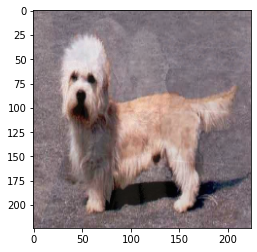

In [ ]:
mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [ ]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_clases=num_classes):
    mixed_imgs = []
    mixed_labels= []
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)
        
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size,3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## 2.4 데이터셋 만들기

In [ ]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
# 배치 단위로 데이터셋을 정렬 후 CutMix와 Mixup을 적용할 수 있도록 수정한 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    
    if not is_test and with_aug:
        ds = ds.map(augment, num_parallel_calls=2)
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls=2)
        
    elif not is_test and with_mixup:
        ds = ds.map(mixup, num_parallel_calls=2)
        
    else:
        ds = ds.map(onehot, num_parallel_calls=2)
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
# augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋 생성
ds_train_orig = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_val = apply_normalize_on_dataset(ds_val, is_test=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

## Step 3. 모델 만들기
- imagenet 데이터로 훈련된 ResNet50 모델 불러오기 & 모델 생성

In [ ]:
# imagenet 데이터로 훈련된 ResNet50 모델 불러오기 & 모델 생성
resnet50_orig = models.Sequential([
    applications.resnet.ResNet50(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224, 224, 3),
    pooling = 'avg'),
    layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet50_aug = models.Sequential([
    applications.resnet.ResNet50(
        include_top=False, 
        weights='imagenet', 
        input_shape=(224, 224, 3), 
        pooling='avg'),
    layers.Dense(num_classes, activation='softmax')
])

In [ ]:
resnet50_cutmix = models.Sequential([
    applications.resnet.ResNet50(
    include_top=False, 
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'),
    layers.Dense(num_classes, activation='softmax')
])

In [ ]:
resnet50_mixup = models.Sequential([
    applications.resnet.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg'
    ),
    layers.Dense(num_classes, activation='softmax')
])

## Step 4. 모델 훈련하기
cutmix(), mixup()를 구현하면서 label을 `One-hot`벡터 형태로 변형했으므로 sparse_categorical_crossentropy 대신 `categorical_crossentropy`: 사용

In [ ]:
EPOCH = 20

tf.random.set_seed(1234)
resnet50_orig.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'])

hist_resnet50_orig = resnet50_orig.fit(
    ds_train_orig, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16), 
    validation_steps=int(ds_info.splits['test[:50%]'].num_examples/16),
    epochs=EPOCH, 
    validation_data=ds_val, 
    verbose=1, 
    use_multiprocessing=True)

Epoch 1/20
750/750 [==============================] - 101s 110ms/step - loss: 2.1824 - accuracy: 0.4527 - val_loss: 3.5788 - val_accuracy: 0.1707
Epoch 2/20
750/750 [==============================] - 82s 109ms/step - loss: 0.6762 - accuracy: 0.8162 - val_loss: 1.0971 - val_accuracy: 0.6854
Epoch 3/20
750/750 [==============================] - 81s 109ms/step - loss: 0.1792 - accuracy: 0.9678 - val_loss: 0.9583 - val_accuracy: 0.7271
Epoch 4/20
750/750 [==============================] - 81s 108ms/step - loss: 0.0482 - accuracy: 0.9958 - val_loss: 0.9097 - val_accuracy: 0.7430
Epoch 5/20
750/750 [==============================] - 82s 110ms/step - loss: 0.0200 - accuracy: 0.9998 - val_loss: 0.9235 - val_accuracy: 0.7402
Epoch 6/20
750/750 [==============================] - 81s 109ms/step - loss: 0.0161 - accuracy: 0.9996 - val_loss: 0.9653 - val_accuracy: 0.7285
Epoch 7/20
750/750 [==============================] - 82s 109ms/step - loss: 0.0495 - accuracy: 0.9959 - val_loss: 1.0863 - val_a

In [ ]:
resnet50_aug.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizers.SGD(learning_rate=0.01), 
    metrics='accuracy')


hist_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16), 
    validation_steps=int(ds_info.splits['test[:50%]'].num_examples/16), 
    epochs=EPOCH, 
    validation_data=ds_val, 
    verbose=1, 
    use_multiprocessing=True)

Epoch 1/20
750/750 [==============================] - 91s 110ms/step - loss: 2.2451 - accuracy: 0.4398 - val_loss: 3.0834 - val_accuracy: 0.2526
Epoch 2/20
750/750 [==============================] - 81s 108ms/step - loss: 0.8704 - accuracy: 0.7513 - val_loss: 1.4157 - val_accuracy: 0.6056
Epoch 3/20
750/750 [==============================] - 81s 108ms/step - loss: 0.4926 - accuracy: 0.8643 - val_loss: 1.5287 - val_accuracy: 0.5826
Epoch 4/20
750/750 [==============================] - 81s 109ms/step - loss: 0.2430 - accuracy: 0.9427 - val_loss: 0.9706 - val_accuracy: 0.7222
Epoch 5/20
750/750 [==============================] - 81s 109ms/step - loss: 0.1160 - accuracy: 0.9793 - val_loss: 0.9917 - val_accuracy: 0.7206
Epoch 6/20
750/750 [==============================] - 82s 109ms/step - loss: 0.0592 - accuracy: 0.9923 - val_loss: 0.9258 - val_accuracy: 0.7407
Epoch 7/20
750/750 [==============================] - 81s 109ms/step - loss: 0.0337 - accuracy: 0.9968 - val_loss: 0.9168 - val_ac

In [ ]:
resnet50_cutmix.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.01), metrics='accuracy')

hist_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix, 
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16), 
    validation_steps=int(ds_info.splits['test[:50%]'].num_examples/16), 
    epochs=EPOCH, 
    validation_data=ds_val, 
    verbose=1, 
    use_multiprocessing=True)

Epoch 1/20
750/750 [==============================] - 93s 112ms/step - loss: 3.8429 - accuracy: 0.2099 - val_loss: 3.0628 - val_accuracy: 0.2530
Epoch 2/20
750/750 [==============================] - 82s 110ms/step - loss: 2.9578 - accuracy: 0.4317 - val_loss: 1.4821 - val_accuracy: 0.5940
Epoch 3/20
750/750 [==============================] - 84s 112ms/step - loss: 2.6353 - accuracy: 0.5351 - val_loss: 1.3512 - val_accuracy: 0.6315
Epoch 4/20
750/750 [==============================] - 82s 110ms/step - loss: 2.4385 - accuracy: 0.6021 - val_loss: 1.1740 - val_accuracy: 0.6796
Epoch 5/20
750/750 [==============================] - 82s 110ms/step - loss: 2.2513 - accuracy: 0.6562 - val_loss: 1.2026 - val_accuracy: 0.6728
Epoch 6/20
750/750 [==============================] - 83s 110ms/step - loss: 2.1525 - accuracy: 0.6924 - val_loss: 1.2368 - val_accuracy: 0.6726
Epoch 7/20
750/750 [==============================] - 82s 110ms/step - loss: 2.0446 - accuracy: 0.7202 - val_loss: 1.2012 - val_ac

In [ ]:
resnet50_mixup.compile(loss='categorical_crossentropy', 
                       optimizer=optimizers.SGD(learning_rate=0.01), 
                       metrics='accuracy')

hist_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16), 
    validation_steps=int(ds_info.splits['test[:50%]'].num_examples/16), 
    epochs=EPOCH, 
    validation_data=ds_val, 
    verbose=1, 
    use_multiprocessing=True)

Epoch 1/20
750/750 [==============================] - 92s 111ms/step - loss: 3.7165 - accuracy: 0.2392 - val_loss: 4.0546 - val_accuracy: 0.0961
Epoch 2/20
750/750 [==============================] - 82s 110ms/step - loss: 2.8705 - accuracy: 0.4695 - val_loss: 1.4887 - val_accuracy: 0.5863
Epoch 3/20
750/750 [==============================] - 82s 110ms/step - loss: 2.5753 - accuracy: 0.5857 - val_loss: 1.6307 - val_accuracy: 0.5478
Epoch 4/20
750/750 [==============================] - 82s 110ms/step - loss: 2.3946 - accuracy: 0.6508 - val_loss: 1.2805 - val_accuracy: 0.6507
Epoch 5/20
750/750 [==============================] - 83s 110ms/step - loss: 2.2569 - accuracy: 0.7038 - val_loss: 1.3590 - val_accuracy: 0.6318
Epoch 6/20
750/750 [==============================] - 85s 113ms/step - loss: 2.1440 - accuracy: 0.7505 - val_loss: 1.1716 - val_accuracy: 0.6754
Epoch 7/20
750/750 [==============================] - 83s 110ms/step - loss: 2.0614 - accuracy: 0.7781 - val_loss: 1.2618 - val_ac

## Step 5. 훈련 과정 시각화

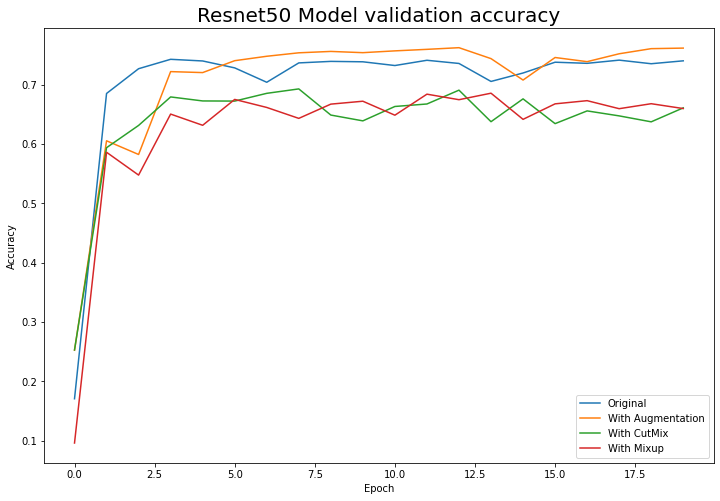

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist_resnet50_orig.history['val_accuracy'])
plt.plot(hist_resnet50_aug.history['val_accuracy'])
plt.plot(hist_resnet50_cutmix.history['val_accuracy'])
plt.plot(hist_resnet50_mixup.history['val_accuracy'])
plt.title('Resnet50 Model validation accuracy', fontsize=20)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Original', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='lower right')
plt.show()

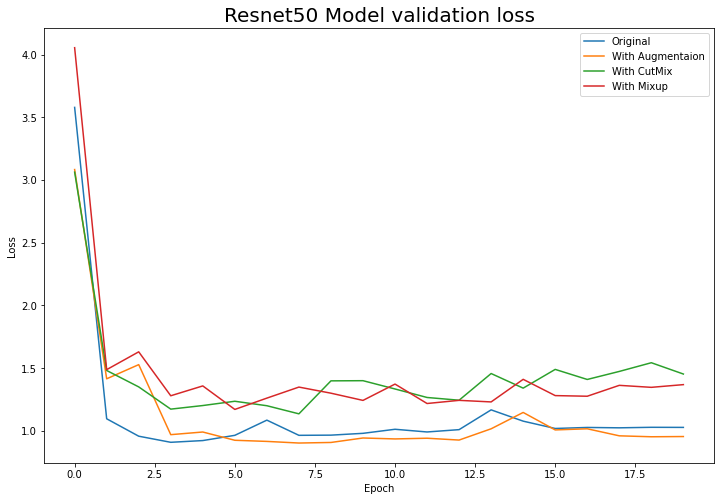

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist_resnet50_orig.history['val_loss'])
plt.plot(hist_resnet50_aug.history['val_loss'])
plt.plot(hist_resnet50_cutmix.history['val_loss'])
plt.plot(hist_resnet50_mixup.history['val_loss'])
plt.title('Resnet50 Model validation loss', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Original', 'With Augmentaion', 'With CutMix', 'With Mixup'], loc='upper right')
plt.show()

## Step 6. ds_test에 대해 accuracy, loss구하기

In [ ]:
loss, accuracy = resnet50_orig.evaluate(ds_test)
print(f'Test accuracy :{accuracy:.4f}, Test loss : {loss:.4f}')

269/269 [==============================] - 9s 34ms/step - loss: 0.9923 - accuracy: 0.7457
Test accuracy :0.7457, Test loss : 0.9923


In [ ]:
loss, accuracy = resnet50_aug.evaluate(ds_test)
print(f'Test accuracy :{accuracy:.4f}, Test loss : {loss:.4f}')

269/269 [==============================] - 9s 33ms/step - loss: 0.9815 - accuracy: 0.7557
Test accuracy :0.7557, Test loss : 0.9815


In [ ]:
loss, accuracy = resnet50_cutmix.evaluate(ds_test)
print(f'Test accuracy :{accuracy:.4f}, Test loss : {loss:.4f}')

269/269 [==============================] - 9s 34ms/step - loss: 1.4216 - accuracy: 0.6692
Test accuracy :0.6692, Test loss : 1.4216


In [ ]:
loss, accuracy = resnet50_mixup.evaluate(ds_test)
print(f'Test accuracy :{accuracy:.4f}, Test loss : {loss:.4f}')

269/269 [==============================] - 9s 33ms/step - loss: 1.3469 - accuracy: 0.6618
Test accuracy :0.6618, Test loss : 1.3469


## Step 7. Augmentaion에 대한 모델 성능비교

### 7.1 Validation Accuracy DataFrame

In [ ]:
acc_data= {'Original': hist_resnet50_orig.history['val_accuracy'], 
           'With Augmentaion': hist_resnet50_aug.history['val_accuracy'], 
           'With  CutMix': hist_resnet50_cutmix.history['val_accuracy'], 
           'With Mixup': hist_resnet50_mixup.history['val_accuracy']}
acc_df = pd.DataFrame(acc_data)
acc_df

,Original,With Augmentaion,With CutMix,With Mixup
0,0.170709,0.252565,0.253032,0.096082
1,0.685401,0.605644,0.593983,0.586287
2,0.727145,0.582556,0.631530,0.547808
3,0.743004,0.722248,0.679571,0.650653
4,0.740205,0.720616,0.672808,0.631763
5,0.728545,0.740672,0.672575,0.675373
6,0.704291,0.748134,0.685634,0.661847
7,0.736940,0.753965,0.693097,0.643423
8,0.739506,0.756297,0.649020,0.667444
9,0.738806,0.754198,0.639226,0.672341


In [ ]:
acc_df.max()

Original            0.743004
With Augmentaion    0.762593
With  CutMix        0.693097
With Mixup          0.685868
dtype: float64

### 7.2 Validation Loss DataFrame

In [ ]:
loss_data= {'Original': hist_resnet50_orig.history['val_loss'], 
           'With Augmentaion': hist_resnet50_aug.history['val_loss'], 
           'With  CutMix': hist_resnet50_cutmix.history['val_loss'], 
           'With Mixup': hist_resnet50_mixup.history['val_loss']}
loss_df = pd.DataFrame(loss_data)
loss_df

,Original,With Augmentaion,With CutMix,With Mixup
0,3.578836,3.083428,3.062771,4.054634
1,1.097089,1.415734,1.482089,1.488741
2,0.958332,1.528651,1.351185,1.630706
3,0.909677,0.970622,1.174048,1.280537
4,0.923476,0.991685,1.202641,1.359027
5,0.965270,0.925810,1.236762,1.171624
6,1.086290,0.916803,1.201151,1.261787
7,0.965253,0.903838,1.136523,1.349752
8,0.966709,0.908384,1.399404,1.301084
9,0.981145,0.943995,1.400716,1.243616


In [ ]:
loss_df.min()

Original            0.909677
With Augmentaion    0.903838
With  CutMix        1.136523
With Mixup          1.171624
dtype: float64

- accuracy, loss를 보면 Augmentation을 적용한 것이 가장 좋은 성적을 가진다.
  - epoch를 조금 더 주었다면 augmentaion을 적용한 데이터셋의 accuracy가 더 올라갈 수도 있었을 것 같다.
- Original dataset, Augmentaion 데이터셋의 과적합이 생겨서 더 accuracy가 안 좋은 것 같다. 
- Augmentaion, cutmix를 같이 데이터셋을 만들었다면 좋았을까??
- 시간이 부족해서 아쉽다...
- 결과를 보자면 cutmix, mixup은 original 데이터셋보다는 좋지 않다.
  - 우리가 사용했던 'standford_dogs' 데이터에는 맞지 않는 방법인 것 같다

- ds_test의 결과는 Augmentation을 적용한 것이 조금 더 좋기는 하나 루브릭을 맞출 수는 없을 것 같다.



## 회고
- 이번 프로젝트에서 **어려웠던 점**
 - ResNet모델을 만드는 것 보다는 편했던 것 같다.
 - 주어진 코드를 활용해서 별로 어려운 점은 없었다.
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**
 - 알아낸 점
   - tensorflow의 dataset를 가져올 때 split하는 법
 - 모호한 점
    - num_pallels_calls를 꼭 2로 줘야하는 건지..
- 루브릭 평가 지표를 맞추기 위해 시도한 것들
  - Albumenation 라이브러리를 활용하고 싶었는 데.. 데이터셋 적용을 하지 못했다.
  - tensorflow의 5가지 Augmentation을 적용했지만. 2개 한 것 보다 좋지는 않다..
- 자기 다짐
  - 열심히 하자!!